In [2]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
layer_size_list = [2,10,1]
np.random.seed(50)
weight_list = [np.random.normal(0,0.1,(layer_size_list[x]+1,layer_size_list[x+1])) for x in range(len(layer_size_list)-1)]
#weight_list = [np.array([[0.1,0.2],[0.3,0.4]]),np.array([[0.2],[1],[-3]]),np.array([[1],[2]])]
no_of_layers = 3
path = 'D:\Courses\Fall 19\ELEG 815 Statistical Learning\HW6\Dataset'
train_data_all = pd.read_csv(path+'\DigitsTraining.csv',header=None)
test_data_all = pd.read_csv(path+'\DigitsTesting.csv',header=None)
train_data = train_data_all.sample(n=500)
test_data = test_data_all.sample(n=500)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def identity(z):
    return z
def feedforward(datapoint,weight_list):
    prev_layer_activations = datapoint
    signal_list = [0]*(no_of_layers-1)
    activations_list = [0]*no_of_layers
    activations_list[0] = datapoint
    for layer in range(1,no_of_layers):     # l= 2 to L
        WX = np.dot(weight_list[layer-1].T,prev_layer_activations)   
        Z = WX
        signal_list[layer-1] = Z
        if layer == 2:
            activation_Z = identity(Z)
        else:
            activation_Z = tanh(Z)
        x_n = np.empty((activation_Z.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = activation_Z
        activations_list[layer] = x_n
        prev_layer_activations = x_n
    return signal_list,activations_list

In [5]:
def backprop(x,y):
    x_n = np.empty((x.shape[0]+1,))
    x_n[0] = 1
    x_n[1:] = x
    s_l,x_l = feedforward(x_n,weight_list)
    delta_L_tanh = 2 * (x_l[-1][1:] - y) * (1 - x_l[-1][1:]*x_l[-1][1:])
    delta_L_identity = 2 * (x_l[-1][1:] - y)
    deltas_list = [0]*(no_of_layers-1)
    deltas_list[-1] = delta_L_identity
    upstream_gradient = delta_L_identity
    for l in range(no_of_layers-2,0,-1):
        theta_dash_s_l = 1 - x_l[l][1:]*x_l[l][1:]
        delta_l = theta_dash_s_l * np.dot(weight_list[l][1:],upstream_gradient)
        upstream_gradient = delta_l
        deltas_list[l-1] = delta_l
    return deltas_list,x_l

In [5]:
def Extract_features(raw_dataset):
    len_dataset = len(raw_dataset)
    number_of_features = 2
    dataset = np.empty((len_dataset,number_of_features))
    true_labels = np.empty((len_dataset,))
    for index,image_pixels in raw_dataset.iterrows():
        """---------------------- Average Intensity-------------------------"""
        avg_intensity = sum(image_pixels[1:])/len(image_pixels[1:])

        """-----------------------Average Symmetry--------------------------"""
        img = np.array(image_pixels[1:]).reshape((16,16))
        flipped_image = np.fliplr(img)
        flipped_image_pixels = flipped_image.flatten()
        image_pixels = np.array(image_pixels)
        asymmetry = sum(np.absolute(image_pixels[1:] - flipped_image_pixels))/len(image_pixels[1:])
        symmetry = 1 - asymmetry
        dataset[index][0] = 1 - avg_intensity           # Higher value of intensity means there are more white pixels than black pixels because white = 255 and black = 0
        dataset[index][1] = symmetry
        if int(image_pixels[0]) == 1:                   # Suppose digit 1 has label = -1
            true_labels[index] = -1
        else:
            true_labels[index] = 1                      # Suppose all other digits have label = +1
    return dataset,true_labels
d_2_train_dataset,d_2_train_labels = Extract_features(train_data)
d_2_test_dataset,d_2_test_labels = Extract_features(test_data)

In [13]:
print(d_2_train_dataset[0])
#print(weight_list[1])

[0.36908789 0.74448047]


In [7]:
def SGD(weight_list,d_2_train_dataset,d_2_train_labels,learning_rate):
    w = weight_list
    D = d_2_train_dataset
    N = len(D)
    y = d_2_train_labels
    E_in = 0
    g = [0] * (no_of_layers-1)
    for index,d in enumerate(D):
        deltas_list,x_l = backprop(d,y[index])
        E_in += (1/N) * (x_l[-1][1] - y[index])**2
        for l in range(1,no_of_layers):
            delta_T = deltas_list[l-1].reshape((deltas_list[l-1].shape[0],1))
            x_l_previos = x_l[l-1].reshape((x_l[l-1].shape[0],1)) 
            G_l_xn = np.dot(x_l_previos,delta_T.T)
            #g[l-1] += (1/N) * G_l_xn
            weight_list[l-1] -= learning_rate * G_l_xn
    print(E_in)
    return E_in,weight_list

In [ ]:
def train_SGD(epochs):
    errors = [0] * epochs
    for epoch in range(epochs):
        print('Epoch :',epoch)
        errors[epoch],weights = SGD(weight_list,d_2_train_dataset,d_2_train_labels,0.01)
    return errors,weight_list
errors_SGD,weight_list_new_SGD = train_SGD(10000)

Text(0,0.5,'Error')

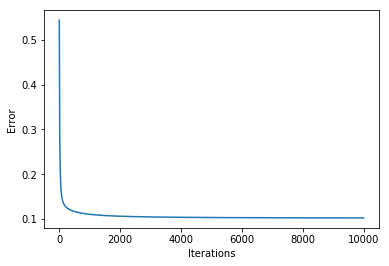

In [9]:
plt.plot(errors_SGD)
plt.xlabel('Iterations')
plt.ylabel('Error')

In [10]:
def evaluate(test_data,test_labels,weight_list_new):
    cnt = 0
    for index,x in enumerate(test_data):
        x_n = np.empty((x.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = x
        x_l = feedforward(x_n,weight_list)[1]
        #print(x_l[-1][1])
        if x_l[-1][1] > 0 and test_labels[index] == 1:
            cnt += 1
        if x_l[-1][1] < 0 and test_labels[index] == -1:
            cnt += 1
    return cnt
cnt = evaluate(d_2_test_dataset,d_2_test_labels,weight_list_new_SGD)

print(cnt)
print((cnt/len(d_2_test_dataset))*100)

486
97.2


Text(0,0.5,'log10(Error)')

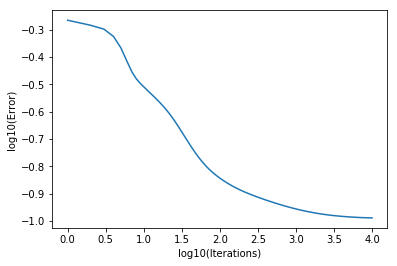

In [11]:
iters = [i for i in range(1,10001)]
plt.plot(np.log10(iters),np.log10(errors_SGD))
plt.xlabel('log10(Iterations)')
plt.ylabel('log10(Error)')